# Check that the reversed ASC is an ACC front

Plot a contour map of SSH overlayed on top of velocity.

Load modules

In [63]:
%matplotlib inline
# Standard modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client
from cosima_cookbook import distributed as ccd
# Optional modules
import cmocean as cm                              # Nice colormaps
import cftime                                     # In case you need to work with time axes
from matplotlib.gridspec import GridSpec
import xarray.ufuncs as xu
import matplotlib.path as mpath
import cartopy.crs as ccrs
import xgcm
import matplotlib.colors as colors
# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

Start a cluster with multiple cores:

In [64]:
client = Client() # n_workers=4
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40339/status,
Dashboard: /proxy/40339/status,Workers: 4
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37241,Workers: 4
Dashboard: /proxy/40339/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://10.0.128.145:44389,Total threads: 4
Dashboard: /proxy/37281/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:43303,


Nominate a database from which to load the data and define an experiment:

In [65]:
# Load database
session = cc.database.create_session()#('/g/data/ik11/databases/ryf9091.db')
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'

In [66]:
lat_slice = slice(-90, -50)

#### Topographic gradient

In [67]:
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()

In [68]:
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

ds = xr.merge([hu, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])

In [69]:
# Take gradient and move to u grid
# Simple gradient over one grid cell. 
# In latitudinal direction, we need to specify what happens at the boundary.
dhu_dx = grid.interp( grid.diff(ds.hu, 'X') / grid.interp(ds.dxu, 'X'), 'X')#, 'Y', boundary='extend')
dhu_dy = grid.interp( grid.diff(ds.hu, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'Y', boundary='extend')# 'X')

# Same as: (other option)
#dhu_dx = grid.interp(grid.diff(ds.hu, 'X'), 'X') / ds.dxu
#dhu_dy = grid.interp(grid.diff(ds.hu, 'Y', boundary='extend'), 'Y', boundary='extend') / ds.dyu

# Select latitude slice
dhu_dx = dhu_dx.sel(yu_ocean=lat_slice)
dhu_dy = dhu_dy.sel(yu_ocean=lat_slice)

In [70]:
# Calculate the magnitude of the topographic slope
slope = xu.sqrt(dhu_dx**2 + dhu_dy**2)

#### Along-slope velocity

In [75]:
start_time = '2080-01-01'
end_time   = '2089-12-31'

u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, frequency='1 monthly')
u = u.sel(time=slice(start_time,end_time)).mean('time').sel(st_ocean=slice(10,100)) # Only top 100 m/ skip surface
u = u.sel(yu_ocean=lat_slice) 
v = cc.querying.getvar(expt, 'v', session, start_time=start_time, end_time=end_time, frequency='1 monthly')
v = v.sel(time=slice(start_time,end_time)).mean('time').sel(st_ocean=slice(10,100))
v = v.sel(yu_ocean=lat_slice) 

1) Depth-average

In [30]:
# hu = cc.querying.getvar(expt, 'hu', session, n=1)
# hu = hu.sel(yu_ocean=lat_slice)

In [72]:
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, start_time=start_time, end_time=end_time, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean':u.yu_ocean,'xu_ocean':u.xu_ocean}, axis=[1,2])

# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))
thickness = thickness.sel(st_ocean=slice(0,500))

In [73]:
u = (u * thickness).sum('st_ocean') / thickness.sum('st_ocean')
v = (v * thickness).sum('st_ocean') / thickness.sum('st_ocean')

2. Rotate to get along-slope component

In [74]:
u_along = u*dhu_dy/slope - v*dhu_dx/slope
u_along = u_along.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
distributed.nanny - WARNING - Restarting wor

ValueError: Could not find dependent ('concatenate-open_dataset-getitem-d7b7cf90e063773914b47c25768dad85', 91, 2, 2, 5).  Check worker logs

#### SSH

In [76]:
ssh = cc.querying.getvar(expt, 'sea_level', session, start_time=start_time, end_time=end_time, frequency='1 monthly')
ssh = ssh.sel(time=slice(start_time,end_time)).mean('time')
ssh = ssh.sel(yt_ocean=lat_slice) 

In [77]:
ssh = ssh.load()

#### Plotting

In [82]:
ft_size  = 22
fig_path = '/g/data/x77/wgh581/Figures/'
plt.rcParams['contour.negative_linestyle'] = 'solid'

In [34]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5#0.455
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [20]:
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

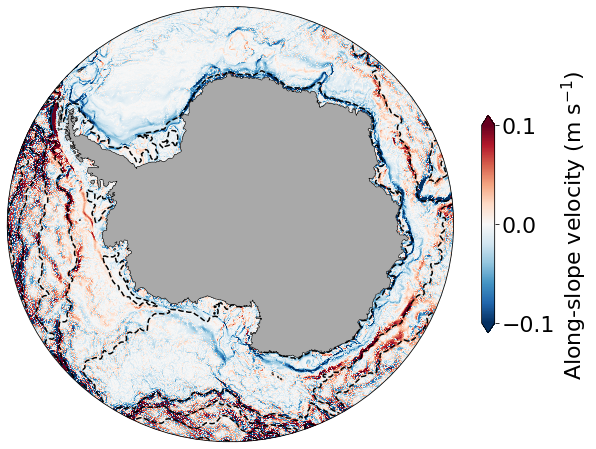

In [40]:
fig = plt.figure(1, figsize=(10,10))

ax = plt.subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)

# Plot land
ax.contourf(slope.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
ax.contour(slope.xu_ocean, slope.yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
sc = ax.pcolormesh(slope.xu_ocean, slope.yu_ocean, u_along, transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.1, vmax=0.1)
cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both', ticks=np.arange(-0.2, 0.25, 0.1), aspect=15)
cbar.set_label('Along-slope velocity (m s$^{-1}$)', fontsize=ft_size, labelpad=5)
cbar.ax.tick_params(labelsize=ft_size)
ax.contour(ssh.xt_ocean, ssh.yt_ocean, ssh, np.arange(-2, -0.4, 0.2), colors='k', transform = ccrs.PlateCarree())

plt.subplots_adjust(wspace=0.01)

# Save figure
save_fig = 0
if save_fig == 1:
    fig.savefig(fig_path + 'Fig_ACC_excursion.png', dpi=150, bbox_inches='tight', facecolor='white')

(-80.0, -59.0)

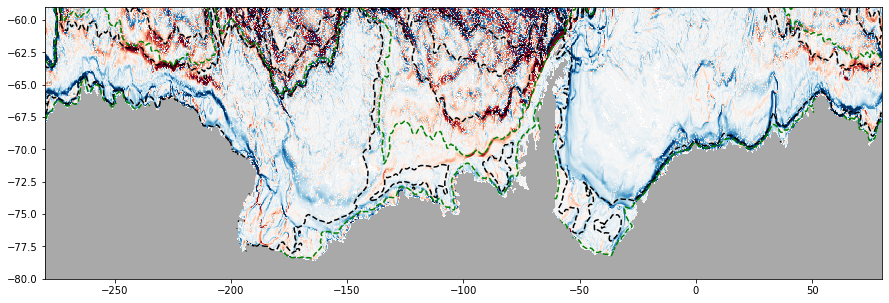

In [51]:
fig = plt.figure(figsize=(15,5))

plt.contourf(slope.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey')
plt.pcolormesh(u_along.xu_ocean, u_along.yu_ocean, u_along, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
plt.contour(ssh.xt_ocean, ssh.yt_ocean, ssh, [-1.8, -1.6, -1.4, -1.2, -1], colors='k')
plt.contour(ssh.xt_ocean, ssh.yt_ocean, ssh, [-1.55], colors='g')
plt.ylim(-80, -59)

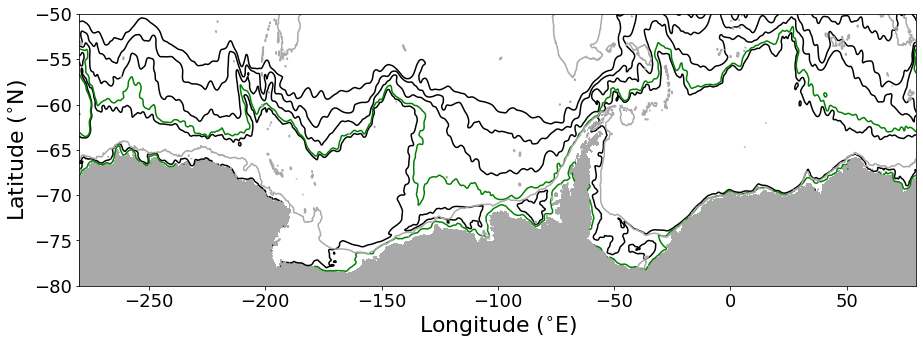

In [92]:
fig = plt.figure(figsize=(15,5))

plt.contourf(slope.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey')
#plt.pcolormesh(u_along.xu_ocean, u_along.yu_ocean, u_along, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
plt.contour(ssh.xt_ocean, ssh.yt_ocean, ssh, [-1.8, -1.6, -1.4, -1.2, -1], colors='k')
plt.contour(ssh.xt_ocean, ssh.yt_ocean, ssh, [-1.55], colors='g')
plt.contour(hu.xu_ocean, hu.yu_ocean, hu, [1000], colors='darkgrey', linewidth=1)
plt.ylim(-80, -50)
plt.xlabel('Longitude ($^{\circ}$E)', fontsize=ft_size)
plt.ylabel('Latitude ($^{\circ}$N)', fontsize=ft_size)
plt.xticks(fontsize=ft_size-4)
plt.yticks(fontsize=ft_size-4);